# Spark Streaming et fenêtres

Use case : Flight tracking with OpenSky

### Imports

In [10]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType, TimestampType, FloatType, BooleanType
from prometheus_client import CollectorRegistry, Gauge, push_to_gateway

from pyspark.sql.functions import col, desc, sum, mean, min, max, lit, coalesce, bucket, col, window, avg ,count,from_json, when, current_timestamp, countDistinct
from matplotlib.pylab import mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [11]:
conf = SparkConf() \
    .setAppName("SparkApp") \
    .setMaster("spark://spark:7077") \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")

# Build the SparkSession using the unified configuration
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Get the SparkContext from the SparkSession (if needed)
sc = spark.sparkContext

# Create a SQLContext (if needed for legacy operations)
sql_context = SQLContext(sc)

print("SparkSession and SparkContext successfully created.")

SparkSession and SparkContext successfully created.


/opt/conda/lib/python3.12/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Configuration kafka et spark

In [12]:
flights_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-flights") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

In [29]:
schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("firstSeen", LongType(), True),
    StructField("estDepartureAirport", StringType(), True),
    StructField("lastSeen", LongType(), True),
    StructField("estArrivalAirport", StringType(), True),
    StructField("estDepartureAirportHorizDistance", LongType(), True),
    StructField("estDepartureAirportVertDistance", LongType(), True),
    StructField("estArrivalAirportHorizDistance", LongType(), True),
    StructField("estArrivalAirportVertDistance", LongType(), True),
    StructField("departureAirportCandidatesCount", LongType(), True),
    StructField("arrivalAirportCandidatesCount", LongType(), True)
])

flights_json = flights_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")


## Requêtes en mode batch, avec état.
### Mode batch avec fenêtre

In [30]:
arrival_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-arrivals") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

arrival_json = arrival_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")

25/02/21 12:18:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Text(0.5, 1.0, "Nombre d'arrivés sur une heure")

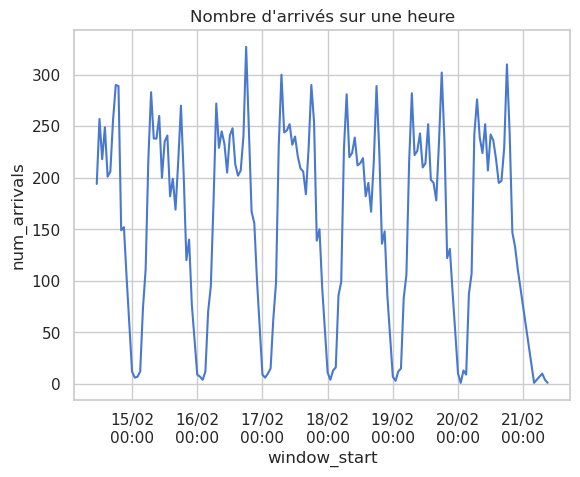

In [ ]:
# Parse Kafka messages
parsed_stream = arrival_df.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select(
        col("data.lastSeen").cast(TimestampType()).alias("ArrivalTime"),
        col("data.estArrivalAirport").alias("Airport")
    )

# Compute number of arrivals over a 60-minute window
rolling_numbers = parsed_stream \
    .groupBy(window(col("ArrivalTime"), "60 minutes")) \
    .count() \
    .select(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("count").alias("num_arrivals")
    ).orderBy("window_start")

# Collect the result as a Pandas DataFrame
pandas_df = rolling_numbers.toPandas()
pandas_df

g = sns.lineplot(data=pandas_df, x="window_start", y="num_arrivals")
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m\n%H:%M'))
g.set_title("Nombre d'arrivés par heures")

### Mode batch sans fenêtre

In [32]:
flight_counts = arrival_json \
    .groupBy("estDepartureAirport", "estArrivalAirport") \
    .count() \
    .withColumnRenamed("count", "flight_count")

# Créer un DataFrame pour les arêtes (vols)
nbVols = flight_counts.select(
    col("estDepartureAirport").alias("src"),
    col("estArrivalAirport").alias("dst"),
    col("flight_count")
)
# on se limite au 15 aéroports les plus fréquentés
top_n = 15

# Identifier les aéroports les plus fréquentés (combinaison de départs et arrivées)
top_airports = (
    flight_counts.select("estDepartureAirport").union(flight_counts.select("estArrivalAirport"))
    .groupBy("estDepartureAirport").count()
    .orderBy(desc("count"))
    .limit(top_n)
    .select("estDepartureAirport").collect()
)
top_airport_codes = [row['estDepartureAirport'] for row in top_airports]

# Filtrer le dataframe pour n'inclure que les vols entre ces aéroports principaux
filtered_counts = flight_counts.filter(
    (col("estDepartureAirport").isin(top_airport_codes)) & 
    (col("estArrivalAirport").isin(top_airport_codes))
)

filtered_counts

25/02/21 12:19:39 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 12:19:39 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


DataFrame[estDepartureAirport: string, estArrivalAirport: string, flight_count: bigint]

25/02/21 12:19:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 12:19:51 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+----+------------+
| src| dst|flight_count|
+----+----+------------+
|LEBL|LEMD|         124|
|LPPT|LEMD|         122|
|LEMD|LEBL|         121|
|EGLL|EHAM|         109|
|EGLL|EDDF|         107|
|LEPA|LEBL|         106|
|LIRF|LEMD|         101|
|EGLL|LFPG|          97|
|EGLL|EDDM|          94|
|LEMD|LIRF|          94|
|EDDF|EDDB|          93|
|EGLL|LEMD|          92|
|EDDM|EDDF|          90|
|LFPG|EHAM|          90|
|EDDB|EDDF|          88|
+----+----+------------+



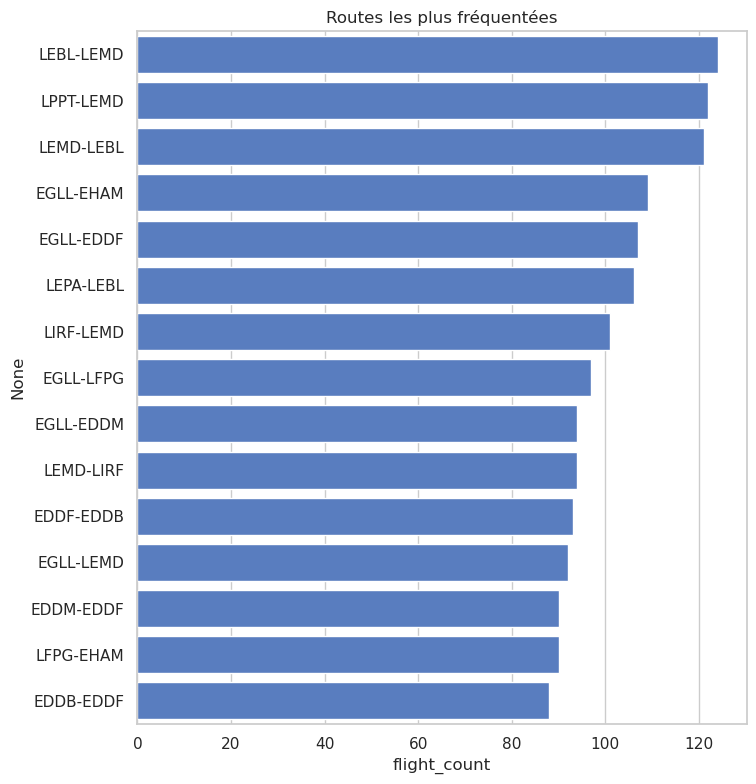

In [33]:
# Filtrer les données qui valent NULL
filtered_nbVols = nbVols.filter(
    (col("src").isNotNull()) & 
    (col("dst").isNotNull())
)

# Trouver les routes les plus empruntées
top_routes = filtered_nbVols.orderBy(desc("flight_count")).limit(top_n)
top_routes.show()

# Convertir en pandas pour visualisation avec Seaborn
top_routes_pd = top_routes.toPandas()

# Créer des visualisations
plt.figure(figsize=(14, 8))

# Graphique des routes les plus fréquentées
plt.subplot(1, 2, 2)
sns.barplot(x="flight_count", y=top_routes_pd.apply(lambda x: f"{x['src']}-{x['dst']}", axis=1), 
            data=top_routes_pd, orient="h")
plt.title("Routes les plus fréquentées")
plt.tight_layout()

plt.savefig("aviation_network_analysis.png")
plt.show()
plt.close()

In [17]:
# Convertir en pandas pour le pivot
matrix_data = filtered_counts.toPandas()

# Créer la matrice pivot
flight_matrix = matrix_data.pivot(index='estDepartureAirport', columns='estArrivalAirport', values='flight_count')
flight_matrix = flight_matrix.fillna(0)  # Remplacer les NaN par 0

# Créer le heatmap
plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    flight_matrix,
    annot=True,           # Afficher les valeurs
    fmt='g',              # Format des nombres (entiers)
    cmap='YlGnBu',        # Palette de couleurs (jaune-vert-bleu)
    linewidths=0.5,       # Lignes entre les cellules
    cbar_kws={'label': 'Nombre de vols'}
)

# Ajuster les étiquettes et le titre
plt.title('Nombre de vols entre les principaux aéroports', fontsize=16)
plt.xlabel('Destinations', fontsize=12)
plt.ylabel('Origines', fontsize=12)

# Rotation des étiquettes pour la lisibilité
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder et afficher
plt.savefig("/tmp/flight_heatmap_origin_destination.png", dpi=300)
# plt.show()
plt.close()

# Obtenir quelques statistiques sur cette matrice
nonzero_routes = (flight_matrix > 0).sum().sum()
total_possible_routes = len(top_airport_codes) * len(top_airport_codes)
connectivity_ratio = nonzero_routes / total_possible_routes

print(f"Parmi les {top_n} principaux aéroports:")
print(f"Nombre total de routes possibles: {total_possible_routes}")
print(f"Nombre de routes effectivement desservies: {nonzero_routes}")
print(f"Ratio de connectivité: {connectivity_ratio:.2%}")
print(f"Nombre moyen de vols par route active: {flight_matrix.sum().sum() / nonzero_routes:.1f}")

25/02/21 11:14:56 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Parmi les 15 principaux aéroports:
Nombre total de routes possibles: 225
Nombre de routes effectivement desservies: 24
Ratio de connectivité: 10.67%
Nombre moyen de vols par route active: 7.5


## Requête avec SparkSQL

In [18]:
# Enregistrer le DataFrame en tant que table temporaire
flights_json.createOrReplaceTempView("flights")

# Top 5 de la correspondance la plus fréquente
query = """
SELECT estDepartureAirport, estArrivalAirport, COUNT(*) as count
FROM flights
WHERE estDepartureAirport IS NOT NULL AND estArrivalAirport IS NOT NULL AND estDepartureAirport != estArrivalAirport
GROUP BY estDepartureAirport, estArrivalAirport
ORDER BY count DESC
LIMIT 5
"""

top_5_couples = sql_context.sql(query)

# Afficher les résultats
top_5_couples.show()

25/02/21 11:15:01 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------------------+-----------------+-----+
|estDepartureAirport|estArrivalAirport|count|
+-------------------+-----------------+-----+
|               KE25|             KDVT|   16|
|               CYVR|             CYYJ|   14|
|               PAEN|             PANC|   10|
|               PANC|             PAEN|   10|
|               KOPF|             KFLL|   10|
+-------------------+-----------------+-----+



## Requête en mode batch et résultats sous forme de graphiques

In [19]:
# Afficher un exemple brut
flights_df.selectExpr("CAST(value AS STRING)").show(5, False)

25/02/21 11:15:03 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
filtered_flights = flights_json.filter(
    (col("estDepartureAirport").isNotNull()) &
    (col("estArrivalAirport").isNotNull())
)

outbound = filtered_flights.groupBy("estDepartureAirport") \
    .agg(count("*").alias("vols_sortants")) \
    .orderBy(desc("vols_sortants"))

inbound = filtered_flights.groupBy("estArrivalAirport") \
    .agg(count("*").alias("vols_entrants")) \
    .orderBy(desc("vols_entrants"))


25/02/21 11:15:03 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 11:15:05 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
/tmp/ipykernel_401/71589102.py:9: FutureWarning:                                

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


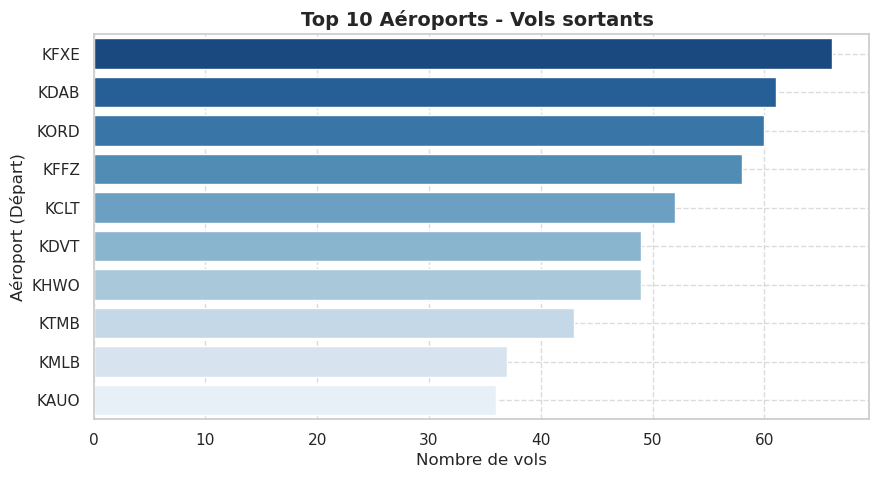

/tmp/ipykernel_401/71589102.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


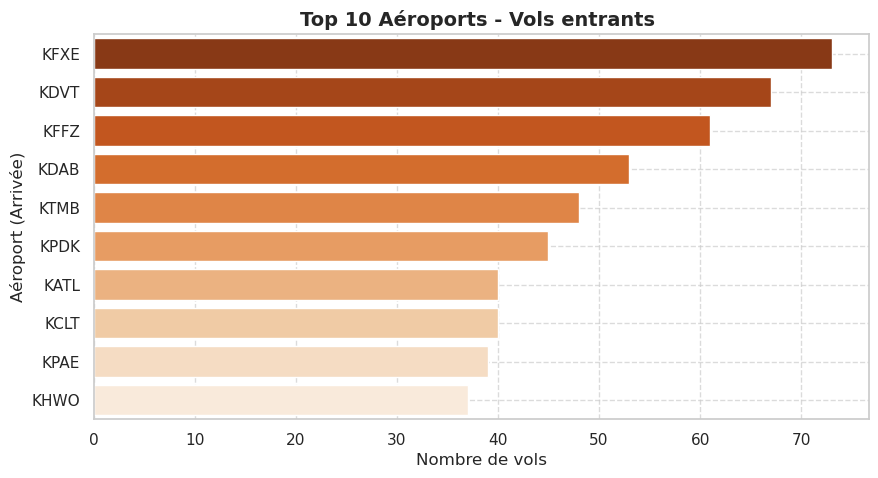

In [21]:
outbound_pd = outbound.limit(10).toPandas()
inbound_pd = inbound.limit(10).toPandas()

# 🎨 Configurer le style Seaborn
sns.set_theme(style="whitegrid", palette="muted")

# 📈 Vols sortants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_sortants",
    y="estDepartureAirport",
    data=outbound_pd,
    palette="Blues_r"
)
plt.title("Top 10 Aéroports - Vols sortants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Départ)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 📊 Vols entrants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_entrants",
    y="estArrivalAirport",
    data=inbound_pd,
    palette="Oranges_r"
)
plt.title("Top 10 Aéroports - Vols entrants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Arrivée)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Spark streaming

## Definir the shema de données states

In [22]:
schema = StructType() \
    .add("icao24", StringType()) \
    .add("callsign", StringType()) \
    .add("origin_country", StringType()) \
    .add("time_position", DoubleType()) \
    .add("last_contact", DoubleType()) \
    .add("longitude", DoubleType()) \
    .add("latitude", DoubleType()) \
    .add("altitude", DoubleType()) \
    .add("on_ground", BooleanType()) \
    .add("velocity", DoubleType()) \
    .add("heading", DoubleType()) \
    .add("vertical_rate", DoubleType()) \
    .add("sensors", StringType()) \
    .add("geo_altitude", DoubleType()) \
    .add("squawk", StringType()) \
    .add("spi", BooleanType()) \
    .add("position_source", StringType())

## Création des Streaming Queries

In [23]:
df_filtered_flights = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky_filtered_flights") \
    .option("startingOffsets", "earliest") \
    .load()

df_filtered_flights = df_filtered_flights.selectExpr("CAST(value AS STRING) as json_value") \
    .select(from_json(col("json_value"), schema).alias("data")) \
    .select("data.*") \
    .withColumn("event_time", current_timestamp())

df_filtered_windowed = df_filtered_flights.groupBy(
    window(col("event_time"), "1 minute"),
    col("origin_country")
).count()

df_bucketed = df_filtered_flights.withColumn(
    "altitude_range",
    when(col("altitude") < 5000, "Low")
    .when((col("altitude") >= 5000) & (col("altitude") < 15000), "Medium")
    .otherwise("High")
)

df_bucket_count = df_bucketed.groupBy(
    window(col("event_time"), "1 minute"),
    col("altitude_range")
).count()

In [ ]:
from prometheus_client import CollectorRegistry, Gauge, push_to_gateway

def push_metrics_to_prometheus(df, epoch_id):
    registry = CollectorRegistry()
    
    gauge = Gauge(
        'filtered_flights_count', 
        'Count of filtered flights per country (per 1-minute window)', 
        ['origin_country'], 
        registry=registry
    )
    
    for row in df.collect():
        country = row['origin_country']
        count_val = row['count']
        gauge.labels(origin_country=country).set(count_val)
    
    push_to_gateway('pushgateway:9091', job='spark_filtered_flights', registry=registry)
    print(f"Epoch {epoch_id}: Metrics pushed to Prometheus Pushgateway.")

query_prometheus = df_filtered_windowed.writeStream \
    .outputMode("update") \
    .foreachBatch(push_metrics_to_prometheus) \
    .start()

query_prometheus.awaitTermination()


25/02/21 12:00:20 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-8b7585bb-36b6-4b89-a623-57c5f483ad88. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/21 12:00:20 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/02/21 12:00:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
def push_bucket_metrics(df, epoch_id):
    registry = CollectorRegistry()
    
    gauge = Gauge(
        'bucketed_flights_count', 
        'Count of flights by altitude range per 1-minute window', 
        ['altitude_range'], 
        registry=registry
    )
    
    # Iterate over each row in the micro-batch DataFrame.
    # Each row should contain the altitude_range and its corresponding count.
    for row in df.collect():
        bucket = row['altitude_range']
        count_val = row['count']
        gauge.labels(altitude_range=bucket).set(count_val)
    
    # Push the metrics to the Pushgateway (ensure the host/port match your configuration)
    push_to_gateway('pushgateway:9091', job='spark_bucketed_flights', registry=registry)
    print(f"Epoch {epoch_id}: Bucket metrics pushed to Prometheus Pushgateway.")

# Attach the foreachBatch function to your bucketed query output
query_bucket_prom = df_bucket_count.writeStream \
    .outputMode("update") \
    .foreachBatch(push_bucket_metrics) \
    .start()

query_bucket_prom.awaitTermination()


## Affichage des Streaming Queries

In [ ]:
query_bucket = df_bucket_count.writeStream \
    .outputMode("complete") \
    .format("console") \
    .queryName("bucket_console_query") \
    .start()

query_filtered = df_filtered_windowed.writeStream \
    .outputMode("update") \
    .format("console") \
    .queryName("filtered_console_query") \
    .start()

# Uncomment the following lines if you wish to block execution:
query_bucket.awaitTermination()
query_filtered.awaitTermination()